[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/floleuerer/ml-tutorials/blob/main/01_fastai_pets.ipynb)

# Vorbereitungen

Python-Pakete von [fast.ai](https://www.fast.ai) installieren und importieren.

In [ ]:
!pip install --upgrade fastai fastcore

In [23]:
from fastai.vision.all import *

# Daten laden

Fast.ai liefert verschiedene Standard-Datensets mit, die häufig für DeepLearning-Benchmarks verwendet werden. Das gebräuchlichste ist das PETS-Dataset. Es besteht aus 37 verschiedenen Hunde- und Katzenrassen und umfasst insgesamt ca. 7400 Bilder.

Datensatz herunterladen und den Pfad als `path`-Variable speichern. Anschlißend die Bilderpfade als `files`-Liste laden.

In [24]:
path = untar_data(URLs.PETS)

In [32]:
(path/'images').ls()

(#7393) [Path('/Users/florian/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_167.jpg'),Path('/Users/florian/.fastai/data/oxford-iiit-pet/images/pug_52.jpg'),Path('/Users/florian/.fastai/data/oxford-iiit-pet/images/basset_hound_112.jpg'),Path('/Users/florian/.fastai/data/oxford-iiit-pet/images/Siamese_193.jpg'),Path('/Users/florian/.fastai/data/oxford-iiit-pet/images/shiba_inu_122.jpg'),Path('/Users/florian/.fastai/data/oxford-iiit-pet/images/Siamese_53.jpg'),Path('/Users/florian/.fastai/data/oxford-iiit-pet/images/Birman_167.jpg'),Path('/Users/florian/.fastai/data/oxford-iiit-pet/images/leonberger_6.jpg'),Path('/Users/florian/.fastai/data/oxford-iiit-pet/images/Siamese_47.jpg'),Path('/Users/florian/.fastai/data/oxford-iiit-pet/images/shiba_inu_136.jpg')...]

In [25]:
files = get_image_files(path/"images")
len(files)

7390

Jupyter Notebooks unterstützt die Anzeige von Bildern. Dazu  müssen wir mit `PILImage.create` ein Bild-Objekt (Variable `img`) und zeigen es an. Um ein anderes Bild anzuzeigen, kannst du die Varible `img_number` ändern und die Zelle erneut ausführen.

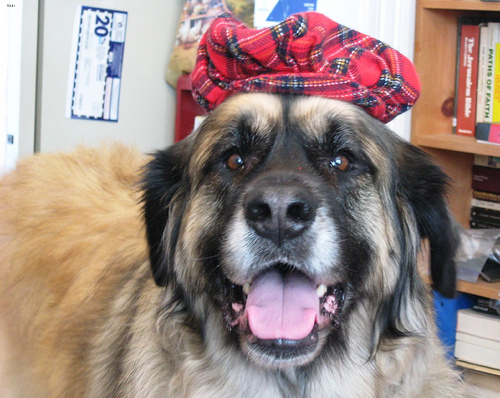

In [26]:
img_number = 7
img = PILImage.create(files[img_number])
img

# Cats-vs-Dogs

Als einfachstes Modell trainieren wir einen Cats-vs-Dogs Classifier. D.h. das Modell wird trainiert um zwischen Hunden und Katzen zu unterscheiden. Dazu machen wir uns zur Nutze, dass die Katzenbilder mit einen Großbuchstaben beginnen (Egyptian_Mau_167.jpg) und die Hundebilder mit kleinbuchstaben (shiba_inu_136.jpg).

In [39]:
def label_func(f): return 'Cat' if f[0].isupper() else 'Dog'

In [40]:
dls = ImageDataLoaders.from_name_func(path, files, label_func, item_tfms=Resize(224))

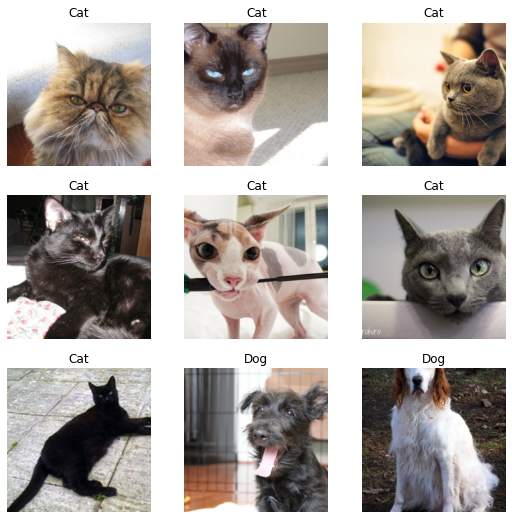

In [41]:
dls.show_batch()

In [22]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

KeyboardInterrupt: 

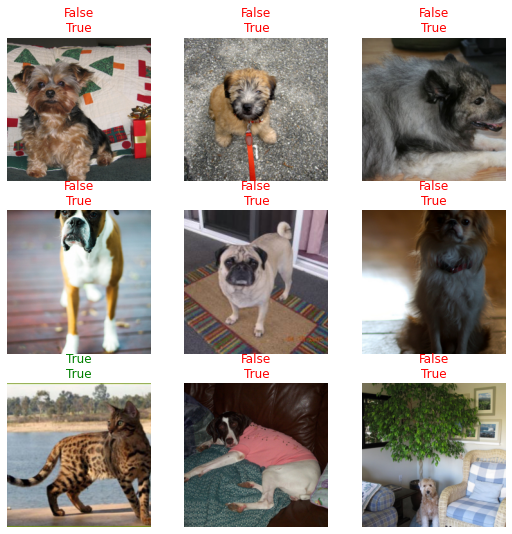

In [42]:
learn.show_results()

In [ ]:
interp = Interpretation.from_learner(learn)

In [ ]:
interp.plot_top_losses(9, figsize=(15,10))

In [ ]:
interp.plot_confusion_matrix()